In [5]:
import pandas as pd
import requests
import zipfile
import io
import datetime
import time
import sys
import matplotlib.pyplot as plt
import numpy as np

In [8]:
#Convert to reading from S3 

def get_rtm_data(utility): 
    if utility == 'SCE': 
        rtm_data= pd.read_excel('~/Downloads/Incremental Revenue Analysis.xlsx', sheet_name='SLAP_SCEN-APND')
    if utility == 'PGE':
        rtm_data= pd.read_excel('~/Downloads/Incremental Revenue Analysis.xlsx', sheet_name='SLAP_PGCC-APND')
    if utility == 'SDGE': 
        rtm_data= pd.read_excel('~/Downloads/Incremental Revenue Analysis.xlsx', sheet_name='SLAP_SDG1-APND')
        
        
    # Add utility to link to partner data after 
#     rtm_data['utility'] == utility
    
    return rtm_data

In [9]:
SCE_rtm=get_rtm_data('SCE')
SCE_rtm

,INTERVALSTARTTIME_GMT,INTERVALENDTIME_GMT,OPR_DT,OPR_HR,NODE_ID_XML,NODE_ID,NODE,MARKET_RUN_ID,LMP_TYPE,XML_DATA_ITEM,PNODE_RESMRID,GRP_TYPE,POS,MW,OPR_INTERVAL,GROUP
0,2021-01-01T08:00:00-00:00,2021-01-01T08:05:00-00:00,2021-01-01,1,SLAP_SCEN-APND,SLAP_SCEN-APND,SLAP_SCEN-APND,RTM,LMP,LMP_PRC,SLAP_SCEN-APND,ALL_APNODES,0,31.16027,1,4
1,2021-01-01T08:05:00-00:00,2021-01-01T08:10:00-00:00,2021-01-01,1,SLAP_SCEN-APND,SLAP_SCEN-APND,SLAP_SCEN-APND,RTM,LMP,LMP_PRC,SLAP_SCEN-APND,ALL_APNODES,0,33.71367,2,4
2,2021-01-01T08:10:00-00:00,2021-01-01T08:15:00-00:00,2021-01-01,1,SLAP_SCEN-APND,SLAP_SCEN-APND,SLAP_SCEN-APND,RTM,LMP,LMP_PRC,SLAP_SCEN-APND,ALL_APNODES,0,34.42815,3,4
3,2021-01-01T08:15:00-00:00,2021-01-01T08:20:00-00:00,2021-01-01,1,SLAP_SCEN-APND,SLAP_SCEN-APND,SLAP_SCEN-APND,RTM,LMP,LMP_PRC,SLAP_SCEN-APND,ALL_APNODES,0,31.75767,4,4
4,2021-01-01T08:20:00-00:00,2021-01-01T08:25:00-00:00,2021-01-01,1,SLAP_SCEN-APND,SLAP_SCEN-APND,SLAP_SCEN-APND,RTM,LMP,LMP_PRC,SLAP_SCEN-APND,ALL_APNODES,0,33.08238,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139099,2022-04-30T07:35:00-00:00,2022-04-30T07:40:00-00:00,2022-04-30,1,SLAP_SCEN-APND,SLAP_SCEN-APND,SLAP_SCEN-APND,RTM,LMP,LMP_PRC,SLAP_SCEN-APND,ALL_APNODES,0,75.52228,8,40
139100,2022-04-30T07:40:00-00:00,2022-04-30T07:45:00-00:00,2022-04-30,1,SLAP_SCEN-APND,SLAP_SCEN-APND,SLAP_SCEN-APND,RTM,LMP,LMP_PRC,SLAP_SCEN-APND,ALL_APNODES,0,71.64924,9,40
139101,2022-04-30T07:45:00-00:00,2022-04-30T07:50:00-00:00,2022-04-30,1,SLAP_SCEN-APND,SLAP_SCEN-APND,SLAP_SCEN-APND,RTM,LMP,LMP_PRC,SLAP_SCEN-APND,ALL_APNODES,0,70.42907,10,40
139102,2022-04-30T07:50:00-00:00,2022-04-30T07:55:00-00:00,2022-04-30,1,SLAP_SCEN-APND,SLAP_SCEN-APND,SLAP_SCEN-APND,RTM,LMP,LMP_PRC,SLAP_SCEN-APND,ALL_APNODES,0,70.07832,11,40


In [24]:
#Convert to reading from Dremio 
def get_dam_data(utility):
    if utility =='SDGE':
        dam_data= pd.read_csv('~/Downloads/dam_prices_sdg1.csv')
    if utility =='SCE':
        dam_data= pd.read_csv('~/Downloads/dam_prices_scen.csv')
    if utility =='PGE':
        dam_data= pd.read_csv('~/Downloads/dam_prices_pgcc.csv')
    
    dam_data['date']=pd.to_datetime(dam_data['local_interval_start'], utc=True)
    dam_data['OPR_DT']=pd.to_datetime(dam_data['date']).dt.date
    dam_data['month']= dam_data['date'].dt.month
    dam_data['hour']=dam_data['date'].dt.strftime("%H")
    
    return dam_data


In [25]:
sce_dam= get_dam_data('SCE')

In [11]:
def determine_target_bids(rtm_df):
    rtm_df['date']=pd.to_datetime(rtm_df['OPR_DT'], utc=True)
    rtm_df['month']= SCE_rtm['date'].dt.month
    target =rtm_df.groupby(['month', 'OPR_HR'])['MW'].agg(['median','mean','std']).reset_index()
    target=target[(target['OPR_HR']>=16) & (target['OPR_HR']<=20)]


    target_bids=target.copy()
    target_bids['conservative']=target['median']+np.where(target['std']>target['median'], 40, target['std'])
    target_bids['moderate']=target['median']
    target_bids['aggressive']=target['median']-np.where(target['std']>target['median'], 0, target['std'])
    return target_bids

def visulaize_bid_strategy(strategy, target_bids):
    if strategy =='aggressive':
        target_bids[strategy].plot.hist(grid=True, bins=20, rwidth=0.9,
                           color='#607c8e')
        plt.title('RTM distribution- Aggressive')
        plt.xlabel('Counts')
        plt.ylabel('Commute Time')
        plt.grid(axis='y', alpha=0.75)
    if strategy =='moderate':
        target_bids[strategy].plot.hist(grid=True, bins=20, rwidth=0.9,
                           color='#607c8e')
        plt.title('RTM distribution- Moderate')
        plt.xlabel('Counts')
        plt.ylabel('Commute Time')
        plt.grid(axis='y', alpha=0.75)
    elif strategy =='conservative':
        target_bids['conservative'].plot.hist(grid=True, bins=20, rwidth=0.9,
                       color='#607c8e')
        plt.title('RTM distribution- Conservative')
        plt.xlabel('Counts')
        plt.ylabel('Commute Time')
        plt.grid(axis='y', alpha=0.75)

    plt.show()
# target_bids

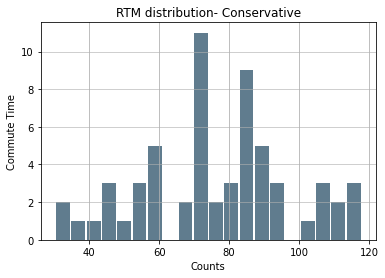

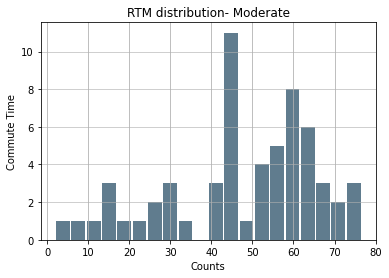

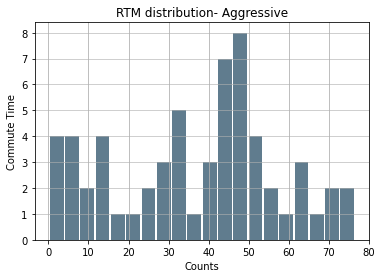

In [12]:
sce_targets= determine_target_bids(SCE_rtm)
sce_conservative_dist=visulaize_bid_strategy('conservative', sce_targets)
sce_moderate_dist=visulaize_bid_strategy('moderate', sce_targets)
sce_aggressive_dist=visulaize_bid_strategy('aggressive', sce_targets)

sce_conservative_dist
sce_moderate_dist
sce_aggressive_dist

In [29]:
sce_dam

,local_interval_start,datetime_hour,pnode,dam_price,fmm_price,rtm_price,date,OPR_DT,month,hour
0,2021-05-01T00:00,2021-05-01T00:00,SCEN,32.18615,34.48061,36.661663,2021-05-01,2021-05-01,5,00
1,2021-05-01T00:15,2021-05-01T00:00,SCEN,32.18615,41.12604,30.206317,2021-05-01,2021-05-01,5,00
2,2021-05-01T00:30,2021-05-01T00:00,SCEN,32.18615,33.07213,31.036587,2021-05-01,2021-05-01,5,00
3,2021-05-01T00:45,2021-05-01T00:00,SCEN,32.18615,30.48581,26.703567,2021-05-01,2021-05-01,5,00
4,2021-05-01T01:00,2021-05-01T01:00,SCEN,31.96077,32.30580,30.957943,2021-05-01,2021-05-01,5,01
...,...,...,...,...,...,...,...,...,...,...
35935,2022-03-11T22:45,2022-03-11T22:00,SCEN,56.67089,52.13117,51.396270,2022-03-11,2022-03-11,3,22
35936,2022-03-11T23:00,2022-03-11T23:00,SCEN,49.60837,52.89224,54.639000,2022-03-11,2022-03-11,3,23
35937,2022-03-11T23:15,2022-03-11T23:00,SCEN,49.60837,51.25378,55.121387,2022-03-11,2022-03-11,3,23
35938,2022-03-11T23:30,2022-03-11T23:00,SCEN,49.60837,52.10272,50.141350,2022-03-11,2022-03-11,3,23


In [32]:
def identify_revenue_opportunities(strategy, rtm_data, target_data, dam_data, moo_hours):
    # merge RTM data with the target data in order to identify opportunities for RTM 
    
    complete=pd.merge(rtm_data, target_data, on=['month', 'OPR_HR'])
    complete=complete.drop(columns=['XML_DATA_ITEM','OPR_INTERVAL','GROUP','NODE_ID_XML','NODE_ID','PNODE_RESMRID','GRP_TYPE','POS','date','month','median','mean','std'])
    complete['date']=pd.to_datetime(complete['INTERVALSTARTTIME_GMT'], utc=True)
    complete['date']=complete["date"].apply(lambda x: x.date)
    complete['INTERVALSTARTTIME_GMT']=pd.to_datetime(complete['INTERVALSTARTTIME_GMT'], utc=True)
    complete['hour']=complete['INTERVALSTARTTIME_GMT'].dt.strftime("%H")
    complete['hour']=complete['hour'].astype(np.int64)

    
    # Unnecessary, but left in anyway: is the target bid being "picked up" independent of DAM price 
    complete['conservative_bid']=(np.where((complete[strategy]<complete['MW']), 
                            'yes','none'))
    complete['moderate_bid']=(np.where((complete[strategy]<complete['MW']), 
                            'yes','none'))
    complete['aggressive_bid']=(np.where((complete[strategy]<complete['MW']), 
                            'yes','none'))
    
#     dam_data['date']=pd.to_datetime(dam_data['local_interval_start'], utc=True)
#     dam_data['date']=dam_data['date'].apply(lambda x: x.date)
#     dam_data['hour']=dam_data['date'].dt.strftime("%H")
    dam_data['hour']=dam_data['hour'].astype(np.int64)
    
    #Marker to determine if LMP is greater than DAM and target price, at which point it would be picked up
    price_discovery_dam_rtm=pd.merge(complete, dam_data, left_on=['date','OPR_HR'], right_on=['date', 'hour'])
    price_discovery_dam_rtm['price']=(np.where(((price_discovery_dam_rtm['dam_price']>price_discovery_dam_rtm['MW'])) | ((price_discovery_dam_rtm['dam_price']<price_discovery_dam_rtm['MW']) & (price_discovery_dam_rtm[strategy]>price_discovery_dam_rtm['MW'])), 
                            'nothing', np.where((price_discovery_dam_rtm['dam_price']<price_discovery_dam_rtm['MW']) & (price_discovery_dam_rtm['MW']>price_discovery_dam_rtm[strategy]),'rtm','nothing')))

    if moo_hours == True: 
        price_discovery_dam_rtm=price_discovery_dam_rtm[(price_discovery_dam_rtm['hour_y']>=16) | (price_discovery_dam_rtm['hour_y']<=20)]
    else: 
        price_discovery_dam_rtm
     
    return price_discovery_dam_rtm


In [45]:
rtm_dam_data_combined= identify_revenue_opportunities('conservative', SCE_rtm, sce_targets, sce_dam, True)
rtm_dam_data_combined

,INTERVALSTARTTIME_GMT,INTERVALENDTIME_GMT,OPR_DT_x,OPR_HR,NODE,MARKET_RUN_ID,LMP_TYPE,MW,conservative,moderate,...,local_interval_start,datetime_hour,pnode,dam_price,fmm_price,rtm_price,OPR_DT_y,month,hour_y,price
0,2022-01-01 23:00:00+00:00,2022-01-01T23:05:00-00:00,2022-01-01,16,SLAP_SCEN-APND,RTM,LMP,-0.01009,45.625525,27.78310,...,2022-01-01T16:00,2022-01-01T16:00,SCEN,80.7996,52.02945,54.995823,2022-01-01,1,16,nothing
1,2022-01-01 23:00:00+00:00,2022-01-01T23:05:00-00:00,2022-01-01,16,SLAP_SCEN-APND,RTM,LMP,-0.01009,45.625525,27.78310,...,2022-01-01T16:15,2022-01-01T16:00,SCEN,80.7996,56.97000,59.018670,2022-01-01,1,16,nothing
2,2022-01-01 23:00:00+00:00,2022-01-01T23:05:00-00:00,2022-01-01,16,SLAP_SCEN-APND,RTM,LMP,-0.01009,45.625525,27.78310,...,2022-01-01T16:30,2022-01-01T16:00,SCEN,80.7996,81.22775,81.002917,2022-01-01,1,16,nothing
3,2022-01-01 23:00:00+00:00,2022-01-01T23:05:00-00:00,2022-01-01,16,SLAP_SCEN-APND,RTM,LMP,-0.01009,45.625525,27.78310,...,2022-01-01T16:45,2022-01-01T16:00,SCEN,80.7996,117.64744,155.793633,2022-01-01,1,16,nothing
4,2022-01-01 23:05:00+00:00,2022-01-01T23:10:00-00:00,2022-01-01,16,SLAP_SCEN-APND,RTM,LMP,-0.01036,45.625525,27.78310,...,2022-01-01T16:00,2022-01-01T16:00,SCEN,80.7996,52.02945,54.995823,2022-01-01,1,16,nothing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98983,2021-12-31 03:50:00+00:00,2021-12-31T03:55:00-00:00,2021-12-30,20,SLAP_SCEN-APND,RTM,LMP,67.20190,71.814154,61.86672,...,2021-12-31T20:45,2021-12-31T20:00,SCEN,74.0000,60.74989,68.639037,2021-12-31,12,20,nothing
98984,2021-12-31 03:55:00+00:00,2021-12-31T04:00:00-00:00,2021-12-30,20,SLAP_SCEN-APND,RTM,LMP,67.07545,71.814154,61.86672,...,2021-12-31T20:00,2021-12-31T20:00,SCEN,74.0000,62.58551,70.436497,2021-12-31,12,20,nothing
98985,2021-12-31 03:55:00+00:00,2021-12-31T04:00:00-00:00,2021-12-30,20,SLAP_SCEN-APND,RTM,LMP,67.07545,71.814154,61.86672,...,2021-12-31T20:15,2021-12-31T20:00,SCEN,74.0000,60.64618,68.947387,2021-12-31,12,20,nothing
98986,2021-12-31 03:55:00+00:00,2021-12-31T04:00:00-00:00,2021-12-30,20,SLAP_SCEN-APND,RTM,LMP,67.07545,71.814154,61.86672,...,2021-12-31T20:30,2021-12-31T20:00,SCEN,74.0000,60.60027,68.367033,2021-12-31,12,20,nothing


In [ ]:
##TO DO: Somehow map the Utility RTM+DAM values to partner data

## if energy event, then assume performance= gen? 
## RTN Baseline? 

##Over payment/umderpayment- if partner typically exceeds nomination in month, model similar use patterns. 

In [63]:
def revenue_totals_from_nominations(rtm_dam_data_combined, partner_data, utility):  
    
#     if sublap is None: 
#         partner_data
#     else: 
#         partner_data = partner_data[(partner_data['utility']) == utility]
        
    partner_data['date']=pd.to_datetime(partner_data['delivery_month'], utc=True)
    partner_data['month']= partner_data['date'].dt.month
    
    rtm_dam_data_combined['date']=pd.to_datetime(rtm_dam_data_combined['OPR_DT_x'], utc=True)
    rtm_dam_data_combined['month']= rtm_dam_data_combined['date'].dt.month

    complete_data=pd.merge(rtm_dam_data_combined, partner_data, on=['date'])
    complete_data['incremental_load_dummy']=complete_data['event_avg_gen_kw']
    complete_data['revenue']=(np.where(complete_data['price'] =='rtm',
                        (((complete_data['MW'])-(complete_data['dam_price']))/1000 * 
                            complete_data['incremental_load_dummy']/12),0))

    complete_data.drop(['fmm_price','rtm_price'], inplace=True, axis=1)
#     complete_data=complete_data.set_index('partner_name').groupby('OPR_DT_x')['revenue'].apply(lambda grp: grp.nlargest(24)).reset_index()
    complete_data

    return complete_data


In [64]:
stem_data=pd.read_csv('~/Downloads/stem_event_data.csv')
test= revenue_totals_from_nominations(rtm_dam_data_combined, stem_data, None)
test.to_csv('~/Downloads/self_directed.csv')

In [40]:
stem_data_managed=pd.read_csv('~/Downloads/stem_managed_bids.csv')
managed_combined= pd.merge(rtm_dam_data_combined, stem_data_managed, on=['local_interval_start'])

managed_combined.to_csv('~/Downloads/figure_it_out.csv')